In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
# from cdo import *
# cdo = Cdo()

from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [2]:
def flip_lon_tll(da):
    # flip 360 to 180 lon
    # for time-lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]
    time_da = da.coords["time"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[time_da,lat_da.values,lon_180],
                          dims=["time","lat","lon"])

    # flip dataarray so it goes from -180 to 180
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)

In [3]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'

ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [4]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [25]:
nh_tas =  masked_tas['tas'].loc[:,'1900-01-01':'2022-12-31',0:90,:]#masked_tas.sel(time=slice('1900-01-01','2014-12-01'),lat=slice(0, 90))
nh_tas = nh_tas - 273.15
# nh_tas_climatology = nh_tas.groupby('time.month').mean(dim='time')
# tas_ano = nh_tas.groupby('time.month') - nh_tas_climatology
tas_ano = nh_tas - nh_tas.mean()
print(tas_ano)
lat = tas_ano['lat']
lon = tas_ano['lon']

<xarray.DataArray 'tas' (run: 30, time: 1476, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1476, 45, 180), dtype=float32, chunksize=(1, 1476, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   float64 2.0
Dimensions without coordinates: run


In [26]:
tas_ano

<xarray.DataArray 'tas' (run: 30, time: 1476, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1476, 45, 180), dtype=float32, chunksize=(1, 1476, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   float64 2.0
Dimensions without coordinates: run

In [27]:
nh_tas['time'] = pd.to_datetime(tas_ano['time'].values)
print(nh_tas['time'])
# Convert the xarray Dataset to a pandas DataFrame
# df = nh_tas.to_dataframe()

# Set the 'time' column as the index of the DataFrame
# df.set_index('time', inplace=True)

<xarray.DataArray 'time' (time: 1476)>
array(['1900-01-16T12:00:00.000000000', '1900-02-15T00:00:00.000000000',
       '1900-03-16T12:00:00.000000000', ..., '2022-10-16T12:00:00.000000000',
       '2022-11-16T00:00:00.000000000', '2022-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
    height   float64 2.0


In [18]:
# nh_mean_anomalies = tas_ano.mean(dim=['lat', 'lon'])
# nh_mean_anomalies


In [10]:
# #monthly data arrange
# tas_ano_number = tas_ano.isel(run=29)
# tas_monthly_data = tas_ano_number.resample(time='1M').mean()
# tas_monthly_data['time']= pd.to_datetime(tas_monthly_data['time'].values)
# tas_monthly_Grouped = tas_monthly_data.groupby('time.month')

# tas_monthly_Grouped

# tas_monthly_arrays = []
# for month, indices in tas_monthly_Grouped.groups.items():
#     group = tas_monthly_data.isel(time=indices)
#     tas_monthly_arrays.append(group.values)

# tas_monthly_arrays
# # len(tas_monthly_arrays)
# # Reshape the input data array to match the desired shape


In [11]:
# # Create the new dimensions and coordinates
# new_dims = {
#     'month': range(1, 13),
#     'year': range(1900, 2015),
#     'lat': tas_ano.lat,
#     'lon': tas_ano.lon
# }

# # Create the new DataArray with the reshaped data and proper dimensions and coordinates
# tas_monthly = xr.DataArray(tas_monthly_arrays, dims=('month', 'year', 'lat', 'lon'), coords=new_dims)

# # Assign year as datetime values
# tas_monthly = tas_monthly.assign_coords(year=pd.to_datetime(tas_monthly.year, format='%Y'))

# print(tas_monthly)

In [12]:
# import statsmodels.api as sm

# # Calculate the Northern Hemisphere averaged SAT anomalies
# nh_mean_anomalies = tas_monthly.mean(dim=['lat', 'lon'])
# nh_mean_anomalies

# nh_mean_15yr = nh_mean_anomalies.sel(year=nh_mean_anomalies.year.dt.year.isin(np.arange(2000, 2014,1)))
# nh_mean_15yr

# df = nh_mean_15yr.to_dataframe('trends')
# display(df)
# # Convert the index to a DatetimeIndex
# #df.index = pd.to_datetime(df.index, format="'(Timestamp('%Y-%m-%d %H:%M:%S'))'")
# df.loc[(1,)]

# # Calculate the trend for each month separately
# month_trends = []
# for month in range(1, 13):
#     monthly_data = df.loc[(month,)]
#     trend = monthly_data.apply(
#         lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
#         axis=0
#     )
#     month_trends.append(trend)

# # Combine the monthly trends into a single DataFrame
# trends_df = pd.concat(month_trends, axis=1, keys=range(1, 13))

# # Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
# trends_da = xr.DataArray(
#     trends_df.values,
#     coords=[trends_df.index, range(1, 13)],
#     dims=['time', 'month']
# )

# # Set the attributes of the trend DataArray
# trends_da.attrs = nh_mean_anomalies.attrs

# trends_da[0,:] = trends_da[0,:]*15.0
# trends_da[0,:]

In [35]:
import statsmodels.api as sm

runs_trends = []
#monthly data arrange
for i in range(1,31):
    tas_ano_number = tas_ano.isel(run=i-1)
    tas_monthly_data = tas_ano_number.resample(time='1M').mean()
    tas_monthly_data['time']= pd.to_datetime(tas_monthly_data['time'].values)
    tas_monthly_Grouped = tas_monthly_data.groupby('time.month')

    tas_monthly_Grouped

    tas_monthly_arrays = []
    for month, indices in tas_monthly_Grouped.groups.items():
        group = tas_monthly_data.isel(time=indices)
        tas_monthly_arrays.append(group.values)

    # type(tas_monthly_arrays)
    # len(tas_monthly_arrays)
    # Create the new dimensions and coordinates
    new_dims = {
        'month': range(1, 13),
        'year': range(1900, 2023),
        'lat': tas_ano.lat,
        'lon': tas_ano.lon
    }

    # Create the new DataArray with the reshaped data and proper dimensions and coordinates
    tas_monthly = xr.DataArray(tas_monthly_arrays, dims=('month', 'year', 'lat', 'lon'), coords=new_dims)

    # Assign year as datetime values
    tas_monthly = tas_monthly.assign_coords(year=pd.to_datetime(tas_monthly.year, format='%Y'))

    # print(tas_monthly)
# len(tas_monthly_arrays)
# Reshape the input data array to match the desired shape
# reshaped_data = np.reshape(tas_monthly_arrays, (30, 12,115, 45, 180))

    # Calculate the Northern Hemisphere averaged SAT anomalies
    nh_mean_anomalies = tas_monthly.mean(dim=['lat', 'lon'])
    nh_mean_anomalies
    
    df = nh_mean_anomalies.to_dataframe(name='SAT Anomaly (C)')
    # display(df)
    # Calculate the trend for each month separately
    month_trends = []
    for month in range(1, 13):
        monthly_data = df.loc[(month,)]
        monthly_trends = []
        for start_year in range(1958, 2009):
            end_year = start_year + 14
            start_date = pd.to_datetime(f"{start_year}-{month}-01")
            end_date = pd.to_datetime(f"{end_year}-{month}-01")
            yearly_data = monthly_data.loc[(monthly_data.index >= start_date) & (monthly_data.index < end_date)]
            trend = yearly_data.apply(
                lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
                axis=0
            )
            monthly_trends.append(trend)
        month_trends.append(monthly_trends)

    # Combine the monthly trends into a single DataFrame
    trends_df = pd.concat([pd.concat([month_trends[i][j] for j in range(len(month_trends[i]))], axis=1, keys=range(1958, 2009)) for i in range(12)], axis=0)
    trends_df

    # Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
    trends_da = xr.DataArray(
        trends_df.values,
        coords=[range(1, 13), range(1958, 2009)],
        dims=['month','start_year']
    )

    # Set the attributes of the trend DataArray
    trends_da.attrs = nh_mean_anomalies.attrs

    trends_da *= 15.0

    runs_trends.append(trends_da)


In [36]:
runs_trends_da = xr.concat(runs_trends, dim='run')
runs_trends_da

<xarray.DataArray (run: 30, month: 12, start_year: 51)>
array([[[ 0.68318452,  0.40399169,  0.11444453, ...,  1.51363746,
          0.94576722,  0.01506373],
        [ 0.62376242, -0.31848112,  0.1255154 , ...,  1.33527167,
          1.07447663,  0.86061092],
        [-1.60443653, -1.34392096, -0.6127818 , ...,  0.23775706,
         -0.43087417, -0.11774746],
        ...,
        [-0.40151724, -0.27852419, -0.28949756, ...,  0.04463203,
          0.16850217,  0.57445431],
        [-0.42518599, -0.72456799, -1.10753599, ..., -0.74008204,
         -0.24097956,  0.00674104],
        [-1.02205939, -1.41373739, -1.44208419, ...,  0.36984717,
          0.35555124,  0.30973381]],

       [[-0.10819232, -0.16076003, -0.09784233, ...,  0.9560482 ,
          1.56275836,  2.21567162],
        [ 0.26163662,  0.72239028,  1.30831935, ..., -0.15081587,
         -0.17247903,  0.0905853 ],
        [ 0.739316  ,  0.80828408,  0.57471191, ...,  0.90965714,
          0.67798136,  1.03648649],
...
        [-0.62314722, -0.44958114, -0.39441561, ...,  0.82882389,
          0.90463417,  0.89294937],
        [-1.0221552 , -1.01697472, -0.74945397, ...,  1.65433071,
          1.449744  ,  0.92536294],
        [-0.57349296,  0.18662207, -0.14731492, ...,  1.18425908,
          1.0295237 ,  0.64473935]],

       [[ 2.03816986,  1.75173955,  0.77884719, ...,  1.40620073,
          1.23544816,  1.05456649],
        [ 0.60537931,  0.55032254,  0.87516167, ...,  2.46026918,
          2.48400907,  2.21863712],
        [ 0.95384762,  0.81759679,  0.5128873 , ...,  1.13369388,
          1.26329573,  1.62130797],
        ...,
        [ 0.86603162,  0.46298793,  0.23588486, ...,  0.44116696,
          0.49625586,  0.33566976],
        [ 1.17041677,  0.9392107 ,  0.83313755, ...,  1.62703513,
          1.76322805,  1.55872595],
        [ 1.05767466,  0.07496965,  0.52087636, ...,  1.23313588,
          0.75709924, -0.00258096]]])
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * start_year  (start_year) int64 1958 1959 1960 1961 ... 2005 2006 2007 2008
Dimensions without coordinates: run

In [38]:
df = runs_trends_da.to_dataframe(name='trend')
df.to_csv('MPI-ESM-30runs-15yrs-running-trend.csv', index=True)


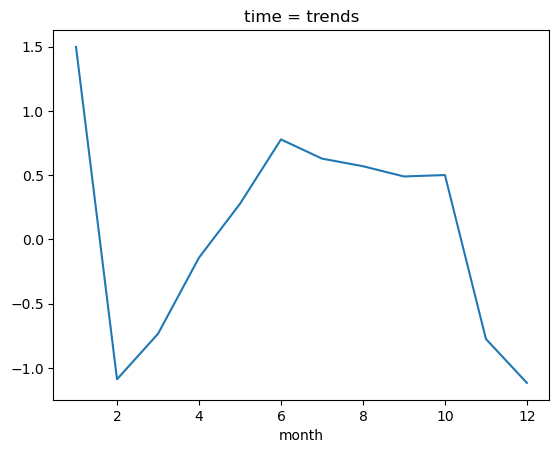

In [47]:
# Calculate the trend for each month 
# 2000-2014
x1 = np.arange(2000, 2015, 1)

trends_da.plot()